<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v2/blob/main/mySector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-11-09 13:43:41


In [ ]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=1747c02f2b0d877ac0471ed75f2c0500e908271b8b74ec904a6d6137b1f2d3f2
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

from google.colab import data_table

In [ ]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [ ]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [ ]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [ ]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [ ]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
13,6148.27,7751.67,6189.0,-0.66,TEXTILES,5348.15,49.0,26.08
0,32230.55,39245.70,32406.0,-0.54,AUTO,22493.81,36.0,21.77
12,4430.20,5186.65,4668.0,-5.09,JEWELLERY,4150.52,35.0,17.07
14,4230.75,4911.95,4268.0,-0.87,FOOTWEAR,3911.23,44.0,16.10
6,3351.82,3824.06,3208.0,4.48,MEDIA,1875.18,51.0,14.09
4,12613.05,14379.52,12574.0,0.31,FMCG,8984.35,39.0,14.01
7,6109.47,6904.04,6101.0,0.14,METAL,4382.20,46.0,13.01
10,40200.70,45422.43,41562.0,-3.28,CEMENT,38503.78,42.0,12.99
2,10064.24,11332.47,10068.0,-0.04,FINANCE,9167.80,46.0,12.60
15,1910.81,2125.54,1639.0,16.58,SUGAR,1276.49,48.0,11.24


<Axes: xlabel='Date'>

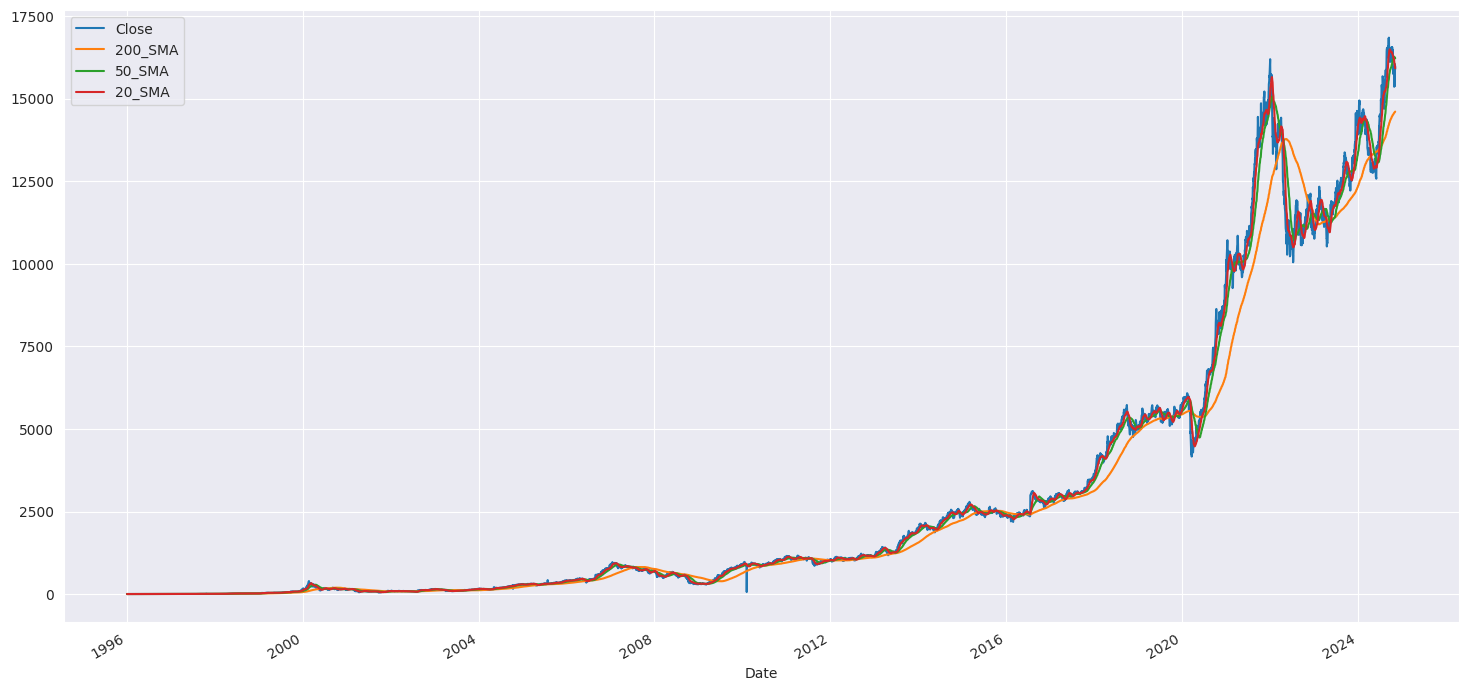

In [ ]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [ ]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
Date,,,,,,,,,,,,,,,,
2023-11-09 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-11-10 00:00:00+05:30,99.351376,100.278201,100.980594,99.907369,100.586748,100.043483,99.529126,100.288694,100.448176,100.010017,101.197176,99.269987,99.496596,99.818177,99.746085,100.934053
2023-11-13 00:00:00+05:30,99.749266,100.172427,100.346978,99.929383,100.682696,100.181938,99.463043,100.717329,100.135090,100.089105,100.776175,99.333540,99.684211,99.369110,98.977712,100.523460
2023-11-15 00:00:00+05:30,100.955649,101.264307,99.002308,102.427120,101.174044,100.218455,99.772936,101.950345,100.879044,99.988153,101.054957,100.099990,99.526157,98.894105,99.709088,101.047145
2023-11-16 00:00:00+05:30,101.786569,101.039950,100.738320,104.928421,101.114488,100.718192,100.014339,101.361003,101.488301,100.405812,101.127413,102.316823,99.790228,98.792586,100.202603,100.410478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04 00:00:00+05:30,139.148987,116.791381,102.089264,122.977745,138.572940,156.308941,97.640756,137.627923,132.011840,127.379084,104.504094,211.480404,99.159597,114.462377,93.026604,137.911874
2024-11-05 00:00:00+05:30,141.599886,119.285294,100.109657,122.883562,138.430758,155.331537,54.204786,140.570904,132.811195,128.341777,104.605972,211.716613,99.376102,111.030956,93.345279,141.235026
2024-11-06 00:00:00+05:30,143.669395,119.440673,104.505047,128.104113,139.782551,157.109408,99.183688,144.485232,134.163635,131.269310,105.859603,225.090145,99.424340,111.886732,94.538100,141.810888


In [ ]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

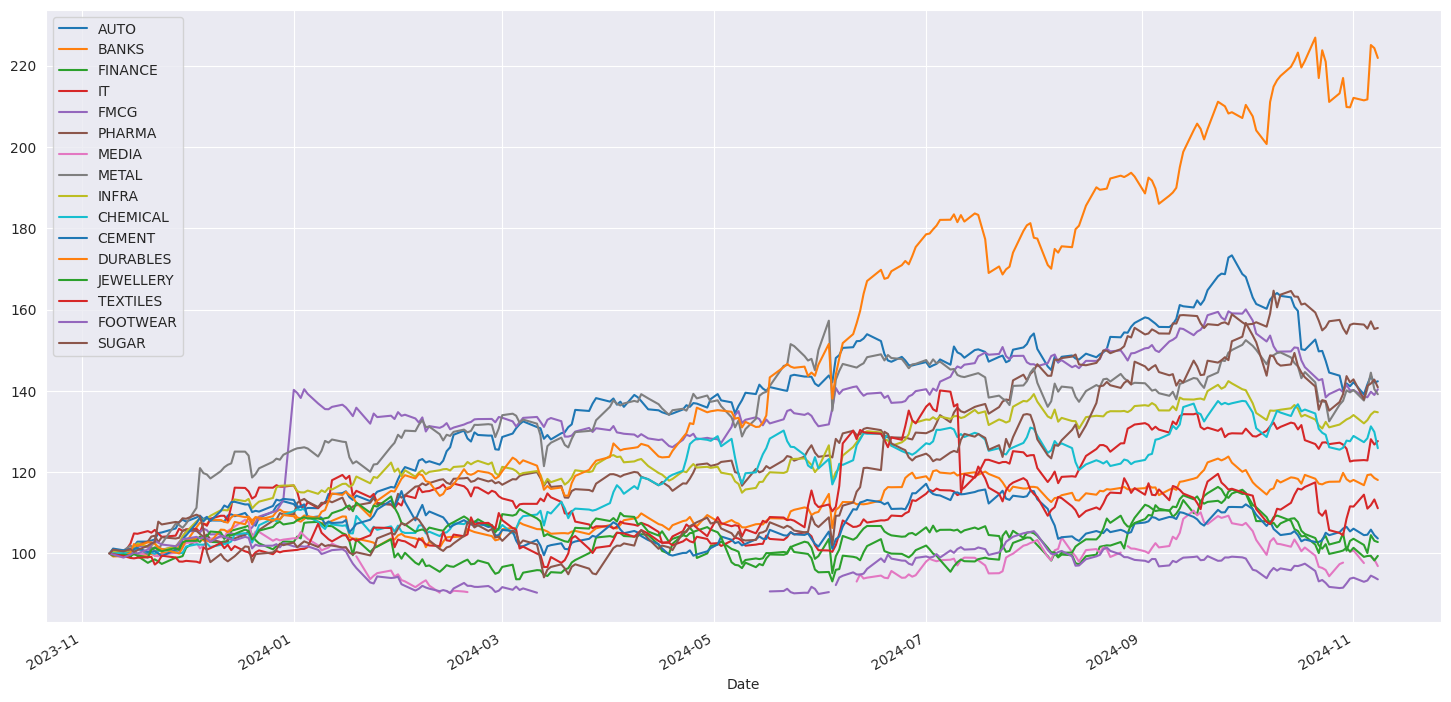

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [ ]:
df_tmp = df_sectors.tail(1).T
df_tmp.columns = ['Close']
df_tmp.sort_values(by = 'Close', ascending=False)

,Close
DURABLES,221.905044
PHARMA,155.481011
AUTO,142.356935
SUGAR,140.889959
FMCG,140.389159
METAL,139.175162
INFRA,134.733087
IT,127.644358
CHEMICAL,125.900107
BANKS,118.073692
